In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import seaborn as sns
from panco2 import PressureProfileFitter
from utils import gNFW
import results
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from fklib import mapview

# NIKA2-like

## Test 0

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, no transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test0/"

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=6.1
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)),
    np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 30)),
    50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])
ppf.add_filtering(beam_fwhm=18.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=False)
results.set_plot_style("seaborn")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.5, imrange="sym")
fig, ax = plt.subplots()
ax.loglog(r_bins, P_bins, "o-")

### Fit

In [ ]:
path = "../tests/test0/"

ppf = PressureProfileFitter(
    f"{path}/map.fits", 1, 2,
    0.865, M_500=3.5e14, map_size=4.0,
)

r_bins = ppf.default_radial_binning(18.0 / 2)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.set_plot_style("seaborn")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

In [ ]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=5e2, max_delta_tau=0.01, min_autocorr_times=100, out_chains_file=f"{path}/raw_chains.npz")
results.plot_acf(ppf, max_delta_tau=0.01, min_autocorr_times=100)

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

## Test 1

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, no transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test1/"

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=4.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
gnfw_par = np.copy(ppf.cluster.A10_params)
gnfw_par[0] *= 3.2 / 8.4
gnfw_par[1] *= 1.0510 / 1.083
gnfw_par[2] = 1.40
gnfw_par[4] = 0.20
P_bins = gNFW(ppf.model.r_bins, *gnfw_par)
par_vec = np.append(P_bins, [-12.0, 0.0])
ppf.add_filtering(beam_fwhm=18.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits")

### Fit

In [ ]:
path = "../tests/test1/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 5
)

ppf.define_model("binned", r_bins)
gnfw_par = np.copy(ppf.cluster.A10_params)
gnfw_par[0] *= 3.2 / 8.4
gnfw_par[1] *= 1.0510 / 1.083
gnfw_par[2] = 1.40
gnfw_par[4] = 0.20
P_bins = gNFW(ppf.model.r_bins, *gnfw_par)
par_vec = np.append(P_bins, [-12.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

## Test 2

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test2/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=5.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])

tf = Table.read("../tests/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)

ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=False)
mapview.fitsview(f"{path}/map.fits", 1, smooth=1.0, imrange="sym")

### Fit

In [ ]:
path = "../tests/test2/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
    map_size=4.0
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 5
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-12.0, 1.2),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
plt.close("all")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

In [ ]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(ppf.autocorr[0], ppf.autocorr[1], "o-")
axs[1].semilogy(ppf.autocorr[0, 1:], np.ediff1d(ppf.autocorr[1]) / ppf.autocorr[1, :-1], "o-")

In [ ]:
np.roll(np.arange(5), 1)

## Test 3

- $M_{500} = 5.5 \times 10^{14} \, M_\odot$, $z= 0.565$
- A10 pressure profile
- 6 arcmin map, 18 arcsec FWHM beam, transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test3/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.565, M_500=5.5e14, map_size=6.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])

tf = Table.read("../tests/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)

ppf.write_sim_map(par_vec, f"{path}/map.fits")

### Fit

In [ ]:
path = "../tests/test3/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.565,
    M_500=5.5e14,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 8
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

# Non-NIKA2

## Test 4

- $M_{500} = 5 \times 10^{14} \, M_\odot$, $z = 0.1$
- A10 pressure profile
- 30 arcmin map, 1 arcmin FWHM beam, no transfer function
- White noise

### Create map

In [ ]:
path = "../tests/test4/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/ACTlike.fits",
    1, 2, 0.1, M_500=5e14, map_size=61.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)), np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 30)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])

ppf.add_filtering(beam_fwhm=60.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=True)
results.set_plot_style("seaborn")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.0, imrange="sym")

### Fit

In [ ]:
path = "../tests/test4/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1, 2, 0.1, M_500=5e14, map_size=11.0
)

#r_bins = np.logspace(
#    np.log10(ppf.cluster.arcsec2kpc(30.0)), np.log10(ppf.cluster.arcsec2kpc(15.0 * 60)), 8
#)

r_bins = ppf.default_radial_binning(60.0)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=60.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(1.0, 0.1),
    zero=ss.norm(0.0, 1e-6)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=0)

In [ ]:
f = ppf.run_mcmc(30, 1e5, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
results.plot_acf(ppf, max_delta_tau=0.01, min_autocorr_times=100)

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 1000, 100)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
#results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, show_probs=False, filename=f"{path}/trace.png")
#fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
#fig.savefig(f"{path}/results.pdf")

# Point sources

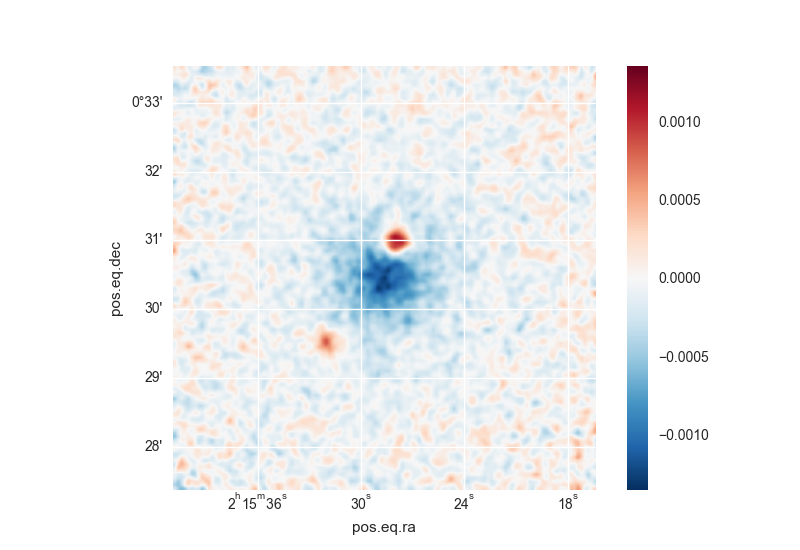

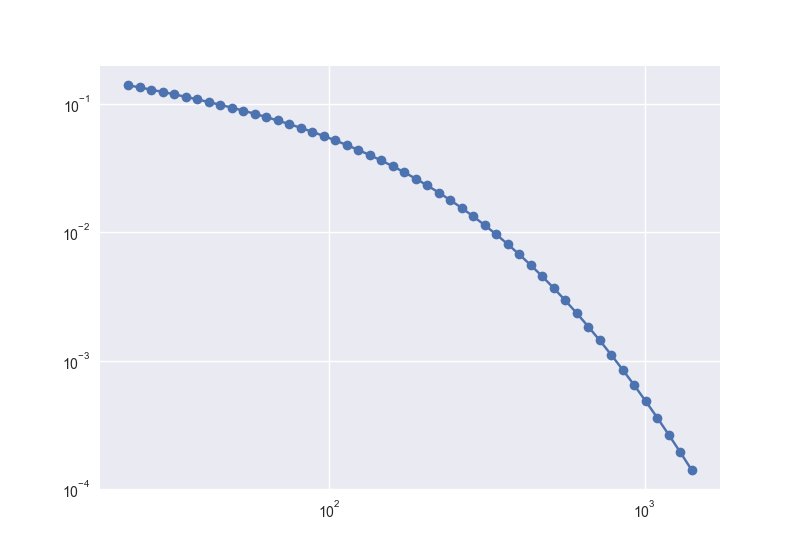

In [3]:
path = "../tests/test5/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=6.1
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)),
    np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 30)),
    50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
ppf.add_filtering(beam_fwhm=18.0)
ppf.add_point_sources([SkyCoord("2h15m32.00s +00d29m30.00s"), SkyCoord("2h15m28.00s +00d31m00.00s")], 18.0)

par_vec = np.append(P_bins, [-12.0, 0.0, 1e-3, 2e-3])
ppf.write_sim_map(par_vec, f"{path}/map.fits", filter_noise=False)
results.set_plot_style("seaborn")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.75, imrange="sym")
fig, ax = plt.subplots()
ax.loglog(r_bins, P_bins, "o-")

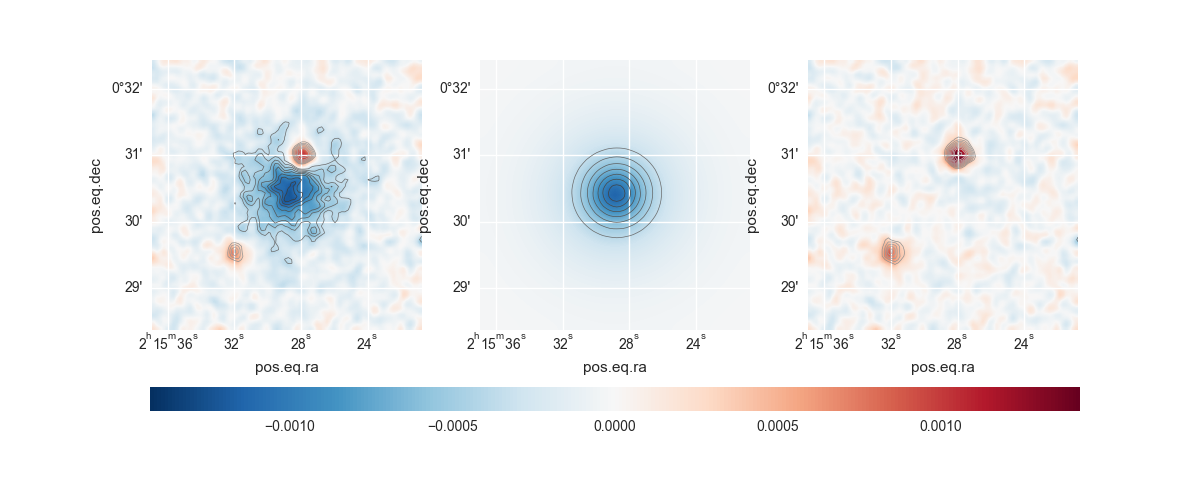

In [4]:
path = "../tests/test5/"

ppf = PressureProfileFitter(
    f"{path}/map.fits", 1, 2,
    0.865, M_500=3.5e14, map_size=4.0,
)

r_bins = ppf.default_radial_binning(18.0 / 2)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0, 1e-3, 2e-3])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.add_point_sources([SkyCoord("2h15m32.00s +00d29m30.00s"), SkyCoord("2h15m28.00s +00d31m00.00s")], 18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4),
    ps_fluxes=[ss.norm(1e-3, 5e-4), ss.norm(2e-3, 1e-2)],
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.set_plot_style("seaborn")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

/Users/fkeruzore/.miniconda3/envs/panco2/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  1%|▉                                                                                              | 502/50000 [00:27<45:49, 18.01it/s]

False False False
    500 iterations = 11.9*tau (tau = 41.9 -> dtau/tau = 1.0000)


  2%|█▉                                                                                            | 1002/50000 [00:55<46:27, 17.58it/s]

False False False
    1000 iterations = 15.6*tau (tau = 63.9 -> dtau/tau = 0.3440)


  3%|██▊                                                                                           | 1502/50000 [01:23<47:11, 17.13it/s]

False False False
    1500 iterations = 19.0*tau (tau = 78.8 -> dtau/tau = 0.1887)


  4%|███▊                                                                                          | 2002/50000 [01:51<46:59, 17.02it/s]

False False False
    2000 iterations = 23.3*tau (tau = 85.9 -> dtau/tau = 0.0833)


  5%|████▋                                                                                         | 2502/50000 [02:19<50:01, 15.82it/s]

False False False
    2500 iterations = 25.5*tau (tau = 98.0 -> dtau/tau = 0.1229)


  6%|█████▋                                                                                        | 3002/50000 [02:48<48:34, 16.12it/s]

False False False
    3000 iterations = 27.9*tau (tau = 107.4 -> dtau/tau = 0.0877)


  7%|██████▌                                                                                       | 3502/50000 [03:16<48:18, 16.04it/s]

False False False
    3500 iterations = 29.8*tau (tau = 117.5 -> dtau/tau = 0.0856)


  8%|███████▌                                                                                      | 4002/50000 [03:44<48:25, 15.83it/s]

False False False
    4000 iterations = 31.6*tau (tau = 126.7 -> dtau/tau = 0.0730)


  9%|████████▍                                                                                     | 4502/50000 [04:12<52:32, 14.43it/s]

False False False
    4500 iterations = 34.5*tau (tau = 130.3 -> dtau/tau = 0.0272)


 10%|█████████▍                                                                                    | 5002/50000 [04:40<50:25, 14.87it/s]

False False False
    5000 iterations = 37.1*tau (tau = 134.8 -> dtau/tau = 0.0335)


 11%|██████████▎                                                                                   | 5502/50000 [05:08<51:00, 14.54it/s]

True False False
    5500 iterations = 40.4*tau (tau = 136.2 -> dtau/tau = 0.0104)


 12%|███████████▎                                                                                  | 6002/50000 [05:36<49:42, 14.75it/s]

False True False
    6000 iterations = 42.8*tau (tau = 140.3 -> dtau/tau = 0.0291)


 13%|████████████▏                                                                                 | 6502/50000 [06:04<55:32, 13.05it/s]

True False False
    6500 iterations = 45.9*tau (tau = 141.5 -> dtau/tau = 0.0090)


 14%|█████████████▏                                                                                | 7002/50000 [06:32<48:25, 14.80it/s]

True True False
    7000 iterations = 48.6*tau (tau = 144.1 -> dtau/tau = 0.0178)


 15%|██████████████                                                                                | 7502/50000 [07:00<48:00, 14.75it/s]

False True False
    7500 iterations = 49.2*tau (tau = 152.3 -> dtau/tau = 0.0539)


 16%|███████████████                                                                               | 8002/50000 [07:28<47:42, 14.67it/s]

True False True
    8000 iterations = 51.7*tau (tau = 154.8 -> dtau/tau = 0.0160)


 17%|███████████████▉                                                                              | 8500/50000 [07:56<38:46, 17.84it/s]


True True True
    8500 iterations = 54.5*tau (tau = 156.0 -> dtau/tau = 0.0075)
    -> Convergence achieved
Running time: 00h07m57s


(<Figure size 800x550 with 2 Axes>,
 array([<AxesSubplot:ylabel='Integrated autocorrelation time $\\tau_i$'>,
        <AxesSubplot:xlabel='MCMC step $i$', ylabel='$|\\tau_{i - 1} - \\tau_{i}| \\; / \\; \\tau_{i}$'>],
       dtype=object))

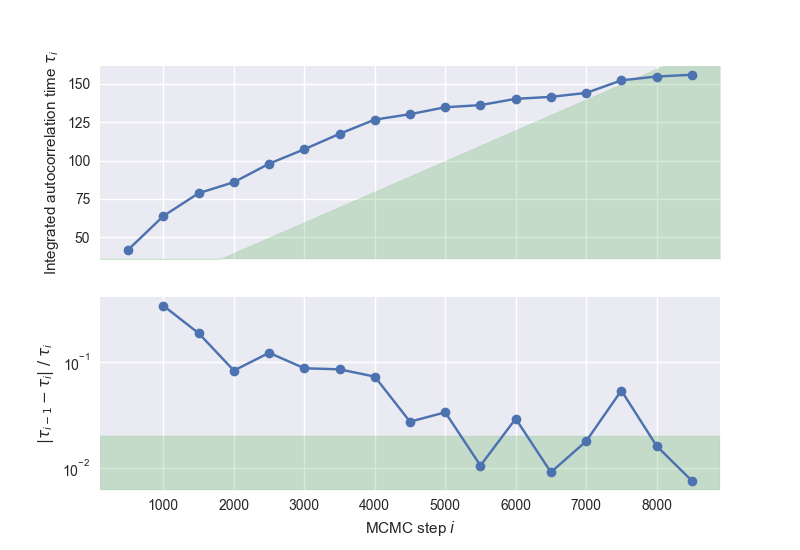

In [6]:
f = ppf.run_mcmc(30, 5e4, 6, n_check=5e2, max_delta_tau=0.02, min_autocorr_times=50, out_chains_file=f"{path}/raw_chains.npz")
results.plot_acf(ppf, max_delta_tau=0.02, min_autocorr_times=50)

In [9]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 500, 20)

In [10]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")

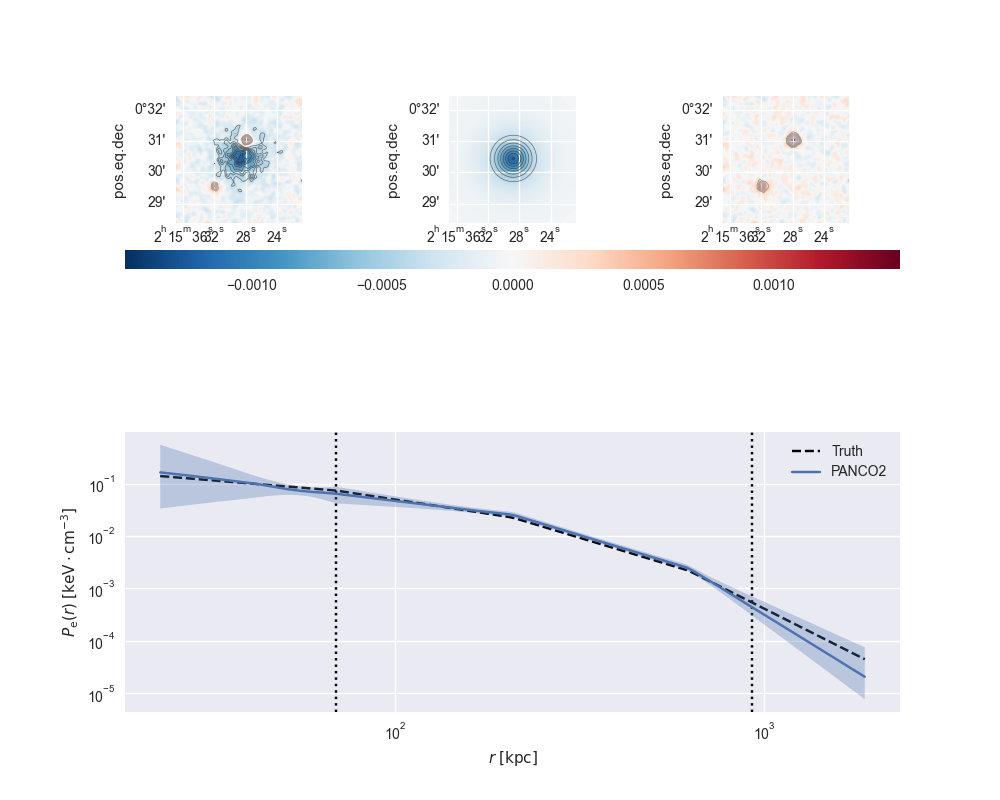

In [11]:
plt.close("all")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")